In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Google Big Query library:
# https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package
import bq_helper
from bq_helper import BigQueryHelper
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import calendar
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from matplotlib import style
style.use('ggplot')

In [2]:
# creating an instance of the database that you can send SQL queries to later and get data back
chicago_taxi = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="chicago_taxi_trips")

Using Kaggle's public dataset BigQuery integration.


In [3]:
# only one table in this "database"
chicago_taxi.list_tables()

['taxi_trips']

In [4]:
chicago_taxi.head("taxi_trips", num_rows=3)

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,1f8a3c41cb64ba14b0621eca39e0b8c99951a699,0500aac38cd3b9c93e714f14b61eb37c7b6d74ca267b02...,2014-07-14 21:30:00+00:00,2014-07-14 21:30:00+00:00,0,0.0,None,None,None,None,6.05,1.82,0.0,0.0,7.87,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
1,1fab8adb848ca6e787c464508d07711ab701f6a9,c369cfd39093ab1019c9df3ba695d949e89290a01c78c2...,2015-11-09 21:15:00+00:00,2015-11-09 21:15:00+00:00,0,0.0,None,None,None,None,6.45,1.94,0.0,0.0,8.39,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
2,1fb960050019efed08e298fb8593a745cc66fddd,8e00dda715e5ab59f03f049f4faa99fcf216fd6815d927...,2015-04-18 02:15:00+00:00,2015-04-18 02:15:00+00:00,0,0.0,None,None,None,None,6.75,1.35,0.0,0.0,8.10,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None


In [6]:
# Select the training data

query = """SELECT trip_start_timestamp,
trip_end_timestamp,
pickup_latitude,
pickup_longitude,
dropoff_latitude,
dropoff_longitude,
trip_seconds,
trip_miles,tolls,trip_total
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_start_timestamp >= '2013-01-01' AND 
                         trip_start_timestamp < '2017-01-01' AND 
                         trip_seconds > 0 AND 
                         trip_miles > 0 AND 
                         trip_total > 0
                         LIMIT 1000000

"""
trainingDataSet = chicago_taxi.query_to_pandas_safe(query, max_gb_scanned=22)
trainingDataSet.dropna(inplace=True)
trainingDataSet.head()

,trip_start_timestamp,trip_end_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,trip_miles,tolls,trip_total
3025,2015-03-27 14:00:00+00:00,2015-03-27 14:15:00+00:00,41.968069,-87.721559,41.968069,-87.721559,720,1.58,0.0,8.65
3026,2013-10-21 15:45:00+00:00,2013-10-21 15:45:00+00:00,41.968069,-87.721559,41.968069,-87.721559,180,0.30,0.0,4.45
3027,2015-01-07 11:45:00+00:00,2015-01-08 00:00:00+00:00,41.968069,-87.721559,41.968069,-87.721559,44100,15.35,0.0,38.93
3028,2014-02-15 07:30:00+00:00,2014-02-15 07:30:00+00:00,41.968069,-87.721559,41.968069,-87.721559,180,0.70,0.0,4.65
3029,2016-07-07 00:45:00+00:00,2016-07-07 00:45:00+00:00,41.968069,-87.721559,41.968069,-87.721559,347,35.50,0.0,11.50


In [7]:
#Feature Generation:

trainingDataSet = trainingDataSet[['trip_start_timestamp', 'trip_end_timestamp', 'trip_miles', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude','dropoff_longitude','trip_seconds','tolls','trip_total']]
trainingDataSet['trip_start_timestamp']=pd.to_datetime(trainingDataSet['trip_start_timestamp'],format='%Y-%m-%d %H:%M:%S UTC')
trainingDataSet['pickup_hrs'] = trainingDataSet['trip_start_timestamp'].dt.hour
trainingDataSet['dropoff_hrs'] = trainingDataSet['trip_end_timestamp'].dt.hour
trainingDataSet['pickup_day']=trainingDataSet['trip_start_timestamp'].apply(lambda x:x.day)
trainingDataSet['pickup_day_of_week']=trainingDataSet['trip_start_timestamp'].apply(lambda x:calendar.day_name[x.weekday()])
trainingDataSet['duration'] = trainingDataSet['trip_seconds']
trainingDataSet['tolls_paid'] = trainingDataSet['tolls'].apply(lambda x: 0 if x == 0 else 1)
trainingDataSet.head()

,trip_start_timestamp,trip_end_timestamp,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,tolls,trip_total,pickup_hrs,dropoff_hrs,pickup_day,pickup_day_of_week,duration,tolls_paid
3025,2015-03-27 14:00:00+00:00,2015-03-27 14:15:00+00:00,1.58,41.968069,-87.721559,41.968069,-87.721559,720,0.0,8.65,14,14,27,Friday,720,0
3026,2013-10-21 15:45:00+00:00,2013-10-21 15:45:00+00:00,0.30,41.968069,-87.721559,41.968069,-87.721559,180,0.0,4.45,15,15,21,Monday,180,0
3027,2015-01-07 11:45:00+00:00,2015-01-08 00:00:00+00:00,15.35,41.968069,-87.721559,41.968069,-87.721559,44100,0.0,38.93,11,0,7,Wednesday,44100,0
3028,2014-02-15 07:30:00+00:00,2014-02-15 07:30:00+00:00,0.70,41.968069,-87.721559,41.968069,-87.721559,180,0.0,4.65,7,7,15,Saturday,180,0
3029,2016-07-07 00:45:00+00:00,2016-07-07 00:45:00+00:00,35.50,41.968069,-87.721559,41.968069,-87.721559,347,0.0,11.50,0,0,7,Thursday,347,0


In [8]:
query = """SELECT trip_start_timestamp,trip_end_timestamp,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,
trip_seconds,tolls,trip_total
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_start_timestamp <= '2017-01-01' AND
      trip_start_timestamp < '2017-08-01' AND
                         trip_seconds > 0 AND 
                         trip_miles > 0 AND trip_total > 0
LIMIT 200000;
"""

testDataSet = chicago_taxi.query_to_pandas_safe(query, max_gb_scanned=22)
testDataSet.dropna(inplace=True)
testDataSet.head()

,trip_start_timestamp,trip_end_timestamp,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,tolls,trip_total
2940,2015-07-08 02:45:00+00:00,2015-07-08 03:00:00+00:00,0.7,41.968069,-87.721559,41.968069,-87.721559,60,0.0,4.45
2941,2016-08-26 02:00:00+00:00,2016-08-26 02:00:00+00:00,0.7,41.968069,-87.721559,41.968069,-87.721559,120,0.0,4.75
2942,2015-05-26 01:45:00+00:00,2015-05-26 01:45:00+00:00,0.5,41.968069,-87.721559,41.968069,-87.721559,180,0.0,4.65
2943,2014-10-16 22:15:00+00:00,2014-10-16 22:15:00+00:00,0.1,41.968069,-87.721559,41.968069,-87.721559,60,0.0,5.45
2944,2016-02-23 06:15:00+00:00,2016-02-23 06:15:00+00:00,1.3,41.968069,-87.721559,41.968069,-87.721559,300,0.0,6.25


In [9]:
testDataSet = testDataSet[['trip_start_timestamp', 'trip_end_timestamp', 'trip_miles', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude','dropoff_longitude','trip_seconds','tolls','trip_total']]
testDataSet['trip_start_timestamp']=pd.to_datetime(testDataSet['trip_start_timestamp'],format='%Y-%m-%d %H:%M:%S UTC')
testDataSet['pickup_hrs'] = testDataSet['trip_start_timestamp'].dt.hour
testDataSet['dropoff_hrs'] = testDataSet['trip_end_timestamp'].dt.hour
testDataSet['pickup_day']=testDataSet['trip_start_timestamp'].apply(lambda x:x.day)
testDataSet['pickup_day_of_week']=testDataSet['trip_start_timestamp'].apply(lambda x:calendar.day_name[x.weekday()])
testDataSet['duration'] = testDataSet['trip_seconds']
testDataSet['tolls_paid'] = testDataSet['tolls'].apply(lambda x: 0 if x == 0 else 1)
testDataSet.head()

,trip_start_timestamp,trip_end_timestamp,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,tolls,trip_total,pickup_hrs,dropoff_hrs,pickup_day,pickup_day_of_week,duration,tolls_paid
2940,2015-07-08 02:45:00+00:00,2015-07-08 03:00:00+00:00,0.7,41.968069,-87.721559,41.968069,-87.721559,60,0.0,4.45,2,3,8,Wednesday,60,0
2941,2016-08-26 02:00:00+00:00,2016-08-26 02:00:00+00:00,0.7,41.968069,-87.721559,41.968069,-87.721559,120,0.0,4.75,2,2,26,Friday,120,0
2942,2015-05-26 01:45:00+00:00,2015-05-26 01:45:00+00:00,0.5,41.968069,-87.721559,41.968069,-87.721559,180,0.0,4.65,1,1,26,Tuesday,180,0
2943,2014-10-16 22:15:00+00:00,2014-10-16 22:15:00+00:00,0.1,41.968069,-87.721559,41.968069,-87.721559,60,0.0,5.45,22,22,16,Thursday,60,0
2944,2016-02-23 06:15:00+00:00,2016-02-23 06:15:00+00:00,1.3,41.968069,-87.721559,41.968069,-87.721559,300,0.0,6.25,6,6,23,Tuesday,300,0


In [11]:
#Getting rid of any records with NA or inf value, as while doing so will cause an issue in log transformation
trainingDataSet = trainingDataSet.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

Text(0.5, 1.0, 'Distribution of Trip Fare')

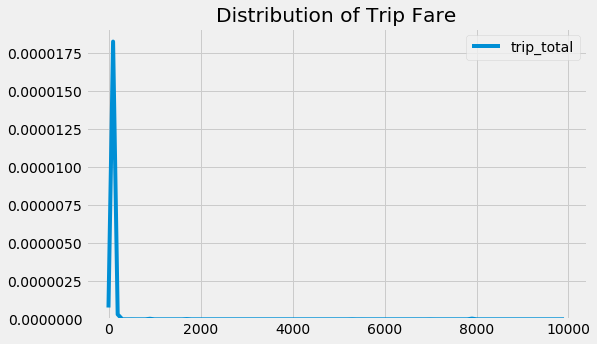

In [12]:
plt.figure(figsize=(8,5))
sns.kdeplot(trainingDataSet['trip_total']).set_title("Distribution of Trip Fare")

Not much informative plot and also it is skewed, let us take log transformation of the fare amount and plot the distribution

Text(0.5, 1.0, 'Distribution of fare amount (log scale)')

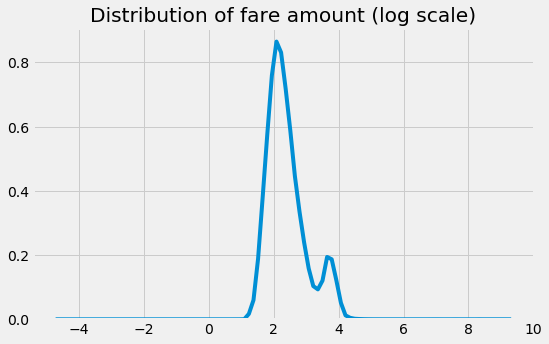

In [13]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(trainingDataSet['trip_total'].values)).set_title("Distribution of fare amount (log scale)")


The most of fares are between 400 to 3000 dollars, and median being at 965.

In [14]:
print("Range of Pickup Latitude is ", (min(trainingDataSet['pickup_latitude']),max(trainingDataSet['pickup_latitude'])))
print("Range of Dropoff Latitude is ", (min(trainingDataSet['dropoff_latitude']),max(trainingDataSet['dropoff_latitude'])))
print("Range of Pickup longitude is ", (min(trainingDataSet['pickup_longitude']),max(trainingDataSet['pickup_longitude'])))
print("Range of Dropoff longitude is ", (min(trainingDataSet['dropoff_longitude']),max(trainingDataSet['dropoff_longitude'])))

Range of Pickup Latitude is  (41.660136051, 42.015934376)
Range of Dropoff Latitude is  (41.660136051, 42.021223593)
Range of Pickup longitude is  (-87.913624596, -87.534902901)
Range of Dropoff longitude is  (-87.913624596, -87.534902901)


In [15]:
pickup_fare_amount=pd.DataFrame(trainingDataSet.groupby(['pickup_latitude','pickup_longitude'])['trip_total'].mean().reset_index().rename(columns={'fare_amount':'avg_fare'}))
pickup_fare_amount.head()

,pickup_latitude,pickup_longitude,trip_total
0,41.660136,-87.602848,25.742500
1,41.663671,-87.540936,35.558333
2,41.673820,-87.635740,33.168750
3,41.689730,-87.669054,26.818750
4,41.690633,-87.570058,24.359048


In [16]:
trainingDataSet.head()

,trip_start_timestamp,trip_end_timestamp,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,tolls,trip_total,pickup_hrs,dropoff_hrs,pickup_day,pickup_day_of_week,duration,tolls_paid
3025,2015-03-27 14:00:00+00:00,2015-03-27 14:15:00+00:00,1.58,41.968069,-87.721559,41.968069,-87.721559,720,0.0,8.65,14,14,27,Friday,720,0
3026,2013-10-21 15:45:00+00:00,2013-10-21 15:45:00+00:00,0.30,41.968069,-87.721559,41.968069,-87.721559,180,0.0,4.45,15,15,21,Monday,180,0
3027,2015-01-07 11:45:00+00:00,2015-01-08 00:00:00+00:00,15.35,41.968069,-87.721559,41.968069,-87.721559,44100,0.0,38.93,11,0,7,Wednesday,44100,0
3028,2014-02-15 07:30:00+00:00,2014-02-15 07:30:00+00:00,0.70,41.968069,-87.721559,41.968069,-87.721559,180,0.0,4.65,7,7,15,Saturday,180,0
3029,2016-07-07 00:45:00+00:00,2016-07-07 00:45:00+00:00,35.50,41.968069,-87.721559,41.968069,-87.721559,347,0.0,11.50,0,0,7,Thursday,347,0


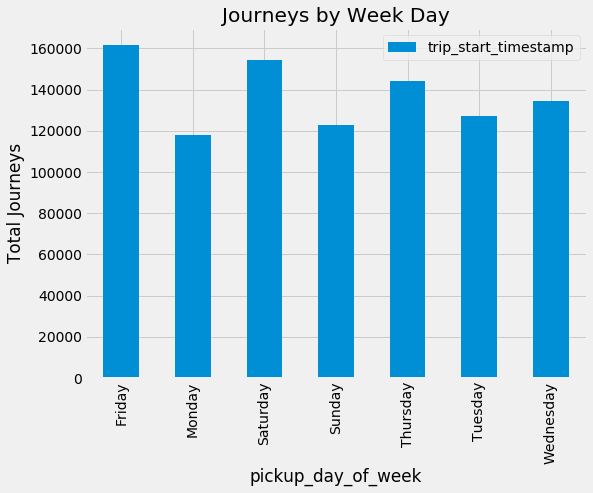

In [17]:
trainingDataSet_weekdays = trainingDataSet.pivot_table(index=['pickup_day_of_week'],
                                  values='trip_start_timestamp',
                                  aggfunc='count')
trainingDataSet_weekdays.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Journeys')
plt.title('Journeys by Week Day');

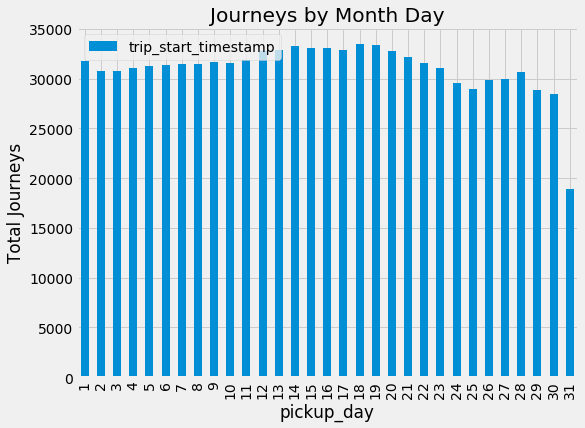

In [18]:
trainingDataSet_monthdays = trainingDataSet.pivot_table(index=['pickup_day'],
                                  values='trip_start_timestamp',
                                  aggfunc='count')
trainingDataSet_monthdays.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Journeys')
plt.title('Journeys by Month Day');

In [19]:
#Getting rid of some outliers from train and test
trainingDataSet = trainingDataSet[ (trainingDataSet['duration'] > 0)]
trainingDataSet = trainingDataSet[ (trainingDataSet['duration'] < 11000)]
#trainingDataSet = trainingDataSet[ (trainingDataSet['speed'] > 6.0)]
#trainingDataSet = trainingDataSet[ (trainingDataSet['speed'] < 140.0)]
trainingDataSet = trainingDataSet[ (trainingDataSet['pickup_longitude'] != 0)]
trainingDataSet = trainingDataSet[ (trainingDataSet['dropoff_longitude'] != 0)]
trainingDataSet = trainingDataSet[ (trainingDataSet['pickup_latitude'] > 38)]
trainingDataSet = trainingDataSet[ (trainingDataSet['pickup_latitude'] < 45)]
trainingDataSet.head()

,trip_start_timestamp,trip_end_timestamp,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,tolls,trip_total,pickup_hrs,dropoff_hrs,pickup_day,pickup_day_of_week,duration,tolls_paid
3025,2015-03-27 14:00:00+00:00,2015-03-27 14:15:00+00:00,1.58,41.968069,-87.721559,41.968069,-87.721559,720,0.0,8.65,14,14,27,Friday,720,0
3026,2013-10-21 15:45:00+00:00,2013-10-21 15:45:00+00:00,0.30,41.968069,-87.721559,41.968069,-87.721559,180,0.0,4.45,15,15,21,Monday,180,0
3028,2014-02-15 07:30:00+00:00,2014-02-15 07:30:00+00:00,0.70,41.968069,-87.721559,41.968069,-87.721559,180,0.0,4.65,7,7,15,Saturday,180,0
3029,2016-07-07 00:45:00+00:00,2016-07-07 00:45:00+00:00,35.50,41.968069,-87.721559,41.968069,-87.721559,347,0.0,11.50,0,0,7,Thursday,347,0
3030,2016-10-25 23:30:00+00:00,2016-10-25 23:30:00+00:00,0.20,41.968069,-87.721559,41.968069,-87.721559,60,0.0,3.75,23,23,25,Tuesday,60,0


In [20]:
testDataSet = testDataSet[ (testDataSet['duration'] > 0)]
testDataSet = testDataSet[ (testDataSet['duration'] < 11000)]
#trainingDataSet = trainingDataSet[ (trainingDataSet['speed'] > 6.0)]
#trainingDataSet = trainingDataSet[ (trainingDataSet['speed'] < 140.0)]
testDataSet = testDataSet[ (testDataSet['pickup_longitude'] != 0)]
testDataSet = testDataSet[ (testDataSet['dropoff_longitude'] != 0)]
testDataSet = testDataSet[ (testDataSet['pickup_latitude'] > 38)]
testDataSet = testDataSet[ (testDataSet['pickup_latitude'] < 45)]
testDataSet.head()

,trip_start_timestamp,trip_end_timestamp,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,tolls,trip_total,pickup_hrs,dropoff_hrs,pickup_day,pickup_day_of_week,duration,tolls_paid
2940,2015-07-08 02:45:00+00:00,2015-07-08 03:00:00+00:00,0.7,41.968069,-87.721559,41.968069,-87.721559,60,0.0,4.45,2,3,8,Wednesday,60,0
2941,2016-08-26 02:00:00+00:00,2016-08-26 02:00:00+00:00,0.7,41.968069,-87.721559,41.968069,-87.721559,120,0.0,4.75,2,2,26,Friday,120,0
2942,2015-05-26 01:45:00+00:00,2015-05-26 01:45:00+00:00,0.5,41.968069,-87.721559,41.968069,-87.721559,180,0.0,4.65,1,1,26,Tuesday,180,0
2943,2014-10-16 22:15:00+00:00,2014-10-16 22:15:00+00:00,0.1,41.968069,-87.721559,41.968069,-87.721559,60,0.0,5.45,22,22,16,Thursday,60,0
2944,2016-02-23 06:15:00+00:00,2016-02-23 06:15:00+00:00,1.3,41.968069,-87.721559,41.968069,-87.721559,300,0.0,6.25,6,6,23,Tuesday,300,0


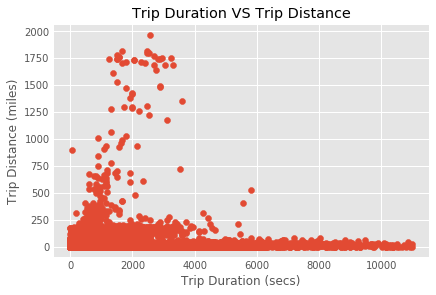

In [22]:
plt.scatter(trainingDataSet['duration'], trainingDataSet['trip_miles'])
plt.title('Trip Duration VS Trip Distance')
plt.xlabel('Trip Duration (secs)')
plt.ylabel('Trip Distance (miles)')
plt.show()

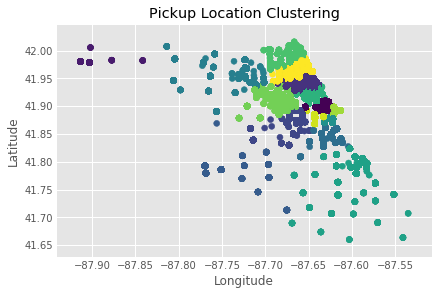

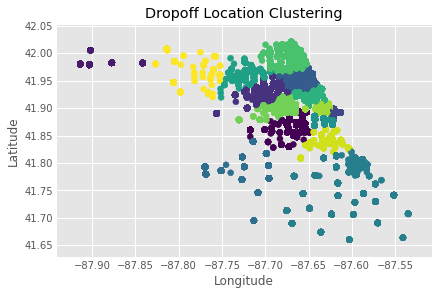

In [23]:
n = len(trainingDataSet)
kmeans_pickup = KMeans(n_clusters = 15, random_state = 2).fit(trainingDataSet[['pickup_latitude', 'pickup_longitude']])
trainingDataSet['kmeans_pickup'] = kmeans_pickup.predict(trainingDataSet[['pickup_latitude','pickup_longitude']])
plt.scatter(trainingDataSet.pickup_longitude[:n], 
            trainingDataSet.pickup_latitude[:n],
            cmap = 'viridis',
            c = trainingDataSet.kmeans_pickup[:n])
plt.title('Pickup Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

kmeans_dropoff = KMeans(n_clusters = 15, random_state = 2).fit(trainingDataSet[['dropoff_latitude', 'dropoff_longitude']])
trainingDataSet['kmeans_dropoff'] = kmeans_dropoff.predict(trainingDataSet[['dropoff_latitude','dropoff_longitude']])
plt.scatter(trainingDataSet.dropoff_longitude[:n], 
            trainingDataSet.dropoff_latitude[:n],
            cmap = 'viridis',
            c = trainingDataSet.kmeans_dropoff[:n])
plt.title('Dropoff Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [24]:
#using the same model of kmeans cluster the test data as well
testDataSet['kmeans_pickup'] = kmeans_pickup.predict(testDataSet[['pickup_latitude','pickup_longitude']])
testDataSet['kmeans_dropoff'] = kmeans_dropoff.predict(testDataSet[['dropoff_latitude','dropoff_longitude']])

In [25]:
#creating dummies for the data which are categorical
trainingDataSet = pd.concat([trainingDataSet, pd.get_dummies(trainingDataSet['pickup_hrs'], prefix = 'hrs')], axis = 1)
trainingDataSet = pd.concat([trainingDataSet, pd.get_dummies(trainingDataSet['pickup_day_of_week'], prefix = 'hrs')], axis = 1)
#trainingDataSet = pd.concat([trainingDataSet, pd.get_dummies(trainingDataSet['day_week'], prefix = 'day')], axis = 1)
trainingDataSet['pickup_dropoff_cluster'] = trainingDataSet['kmeans_pickup'].map(str) + 'to' +  trainingDataSet['kmeans_dropoff'].map(str)
trainingDataSet = pd.concat([trainingDataSet, pd.get_dummies(trainingDataSet['pickup_dropoff_cluster'], prefix = 'route')], axis = 1)
trainingDataSet.head()

,trip_start_timestamp,trip_end_timestamp,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,tolls,trip_total,pickup_hrs,dropoff_hrs,pickup_day,pickup_day_of_week,duration,tolls_paid,kmeans_pickup,kmeans_dropoff,hrs_0,hrs_1,hrs_2,hrs_3,hrs_4,hrs_5,hrs_6,hrs_7,hrs_8,hrs_9,hrs_10,hrs_11,hrs_12,hrs_13,hrs_14,hrs_15,hrs_16,hrs_17,hrs_18,hrs_19,hrs_20,hrs_21,...,route_7to13,route_7to14,route_7to2,route_7to3,route_7to4,route_7to5,route_7to6,route_7to7,route_7to8,route_7to9,route_8to0,route_8to1,route_8to10,route_8to11,route_8to12,route_8to13,route_8to14,route_8to2,route_8to3,route_8to4,route_8to5,route_8to6,route_8to7,route_8to8,route_8to9,route_9to0,route_9to1,route_9to10,route_9to11,route_9to12,route_9to13,route_9to14,route_9to2,route_9to3,route_9to4,route_9to5,route_9to6,route_9to7,route_9to8,route_9to9
3025,2015-03-27 14:00:00+00:00,2015-03-27 14:15:00+00:00,1.58,41.968069,-87.721559,41.968069,-87.721559,720,0.0,8.65,14,14,27,Friday,720,0,6,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3026,2013-10-21 15:45:00+00:00,2013-10-21 15:45:00+00:00,0.30,41.968069,-87.721559,41.968069,-87.721559,180,0.0,4.45,15,15,21,Monday,180,0,6,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3028,2014-02-15 07:30:00+00:00,2014-02-15 07:30:00+00:00,0.70,41.968069,-87.721559,41.968069,-87.721559,180,0.0,4.65,7,7,15,Saturday,180,0,6,8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3029,2016-07-07 00:45:00+00:00,2016-07-07 00:45:00+00:00,35.50,41.968069,-87.721559,41.968069,-87.721559,347,0.0,11.50,0,0,7,Thursday,347,0,6,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3030,2016-10-25 23:30:00+00:00,2016-10-25 23:30:00+00:00,0.20,41.968069,-87.721559,41.968069,-87.721559,60,0.0,3.75,23,23,25,Tuesday,60,0,6,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
testDataSet = pd.concat([testDataSet, pd.get_dummies(testDataSet['pickup_hrs'], prefix = 'hrs')], axis = 1)
testDataSet = pd.concat([testDataSet, pd.get_dummies(testDataSet['pickup_day_of_week'], prefix = 'day')], axis = 1)
testDataSet['pickup_dropoff_cluster'] = testDataSet['kmeans_pickup'].map(str) + 'to' +  testDataSet['kmeans_dropoff'].map(str)
testDataSet = pd.concat([testDataSet, pd.get_dummies(testDataSet['pickup_dropoff_cluster'], prefix = 'route')], axis = 1)
testDataSet.head()

,trip_start_timestamp,trip_end_timestamp,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,tolls,trip_total,pickup_hrs,dropoff_hrs,pickup_day,pickup_day_of_week,duration,tolls_paid,kmeans_pickup,kmeans_dropoff,hrs_0,hrs_1,hrs_2,hrs_3,hrs_4,hrs_5,hrs_6,hrs_7,hrs_8,hrs_9,hrs_10,hrs_11,hrs_12,hrs_13,hrs_14,hrs_15,hrs_16,hrs_17,hrs_18,hrs_19,hrs_20,hrs_21,...,route_7to12,route_7to13,route_7to14,route_7to2,route_7to3,route_7to4,route_7to5,route_7to6,route_7to7,route_7to8,route_7to9,route_8to0,route_8to1,route_8to10,route_8to11,route_8to12,route_8to13,route_8to14,route_8to2,route_8to3,route_8to4,route_8to5,route_8to6,route_8to7,route_8to8,route_8to9,route_9to0,route_9to1,route_9to10,route_9to11,route_9to12,route_9to13,route_9to14,route_9to2,route_9to3,route_9to4,route_9to5,route_9to6,route_9to7,route_9to9
2940,2015-07-08 02:45:00+00:00,2015-07-08 03:00:00+00:00,0.7,41.968069,-87.721559,41.968069,-87.721559,60,0.0,4.45,2,3,8,Wednesday,60,0,6,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2941,2016-08-26 02:00:00+00:00,2016-08-26 02:00:00+00:00,0.7,41.968069,-87.721559,41.968069,-87.721559,120,0.0,4.75,2,2,26,Friday,120,0,6,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2942,2015-05-26 01:45:00+00:00,2015-05-26 01:45:00+00:00,0.5,41.968069,-87.721559,41.968069,-87.721559,180,0.0,4.65,1,1,26,Tuesday,180,0,6,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2943,2014-10-16 22:15:00+00:00,2014-10-16 22:15:00+00:00,0.1,41.968069,-87.721559,41.968069,-87.721559,60,0.0,5.45,22,22,16,Thursday,60,0,6,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2944,2016-02-23 06:15:00+00:00,2016-02-23 06:15:00+00:00,1.3,41.968069,-87.721559,41.968069,-87.721559,300,0.0,6.25,6,6,23,Tuesday,300,0,6,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
#pd.DataFrame(trainingDataSet.columns)

#List of desired columns in modelling
hrs_colNames = trainingDataSet.columns[trainingDataSet.columns.str.contains(pat = 'hrs_')] 
day_colNames = trainingDataSet.columns[trainingDataSet.columns.str.contains(pat = 'day_')] 
route_colNames = trainingDataSet.columns[trainingDataSet.columns.str.contains(pat = 'route_')] 

dummy_cols = hrs_colNames.append(day_colNames).append(route_colNames)


In [30]:
#creating columns in test data which are available in train
extra_cols = list(set(trainingDataSet.columns).difference(testDataSet.columns))
for newcol in extra_cols:
    testDataSet[newcol]=0

In [31]:
final_colList = dummy_cols.insert(0,"trip_miles").insert(0,"duration").insert(0,"tolls_paid").insert(0,'trip_total')
final_colList
trainingDataSet_numerical = trainingDataSet[final_colList]
testDataSet_numerical = testDataSet[final_colList]


In [32]:
#Divide the data into train and test

y = np.array(trainingDataSet_numerical['duration'])

X = trainingDataSet_numerical.drop(columns="duration")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train = X_train.apply(pd.to_numeric, errors='ignore')
X_test = X_test.apply(pd.to_numeric, errors='ignore')


In [33]:
#getting rid of unwanted categorical column
X_train.drop(["pickup_day_of_week"],inplace = True,axis=1)
X_test.drop(["pickup_day_of_week"],inplace = True,axis=1)

In [38]:
#Apply the RF model to trai
clf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [34]:
#function for calculating MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
#Evaluate on test data(20% of the train dataset)
y_pred = clf.predict(X=X_test)
mean_absolute_percentage_error(y_test, y_pred)

22.834448665725432

In [35]:
#Validation data
y_FinalTest = np.array(testDataSet_numerical['duration'])

X_FinalTest = testDataSet_numerical.drop(columns="duration")
X_FinalTest = X_FinalTest.drop(columns="pickup_day_of_week")

In [41]:
#Final results from RF model
preds = clf.predict(X_test)

print("MAPE on Test Data from RF model:",mean_absolute_percentage_error(y_test, preds))
y_pred_FinalTest = clf.predict(X=X_FinalTest)
print("MAPE on Validation Data from RF model:",mean_absolute_percentage_error(y_FinalTest, y_pred_FinalTest))



MAPE on Test Data from RF model: 22.834448665725432
MAPE on Validation Data from RF model: 22.117505163278945


In [ ]:
#Apply XG boost model
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

print("MAPE on Test Data:",mean_absolute_percentage_error(y_test, preds))
y_xgpred_FinalTest = xg_reg.predict(X_FinalTest)
print("MAPE on Test Data:",mean_absolute_percentage_error(y_FinalTest, y_xgpred_FinalTest))


In [36]:
#Apply MLP/ Neural Network Regressor
mlp = MLPRegressor(hidden_layer_sizes=(13,13,13),max_iter=500)
mlp.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [42]:
preds = mlp.predict(X_test)

print("MAPE on Test Data from MLP Regressor model:",mean_absolute_percentage_error(y_test, preds))
y_mlpred_FinalTest = mlp.predict(X_FinalTest)
print("MAPE on Validation Data from MLP Regressor model:",mean_absolute_percentage_error(y_FinalTest, y_mlpred_FinalTest))

MAPE on Test Data from MLP Regressor model: 25.962939190400718
MAPE on Validation Data from MLP Regressor model: 26.54614513523579
